In [214]:
#!usr/bin/env python3

In [240]:
#Import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, mean_absolute_error
from scipy.stats import skew

In [216]:
#Read in shipping datasets

X_train = pd.read_csv('archive-4/X_train.csv')
X_test = pd.read_csv('archive-4/X_test.csv')
y_train = pd.read_csv('archive-4/y_train.csv')
y_test = pd.read_csv('archive-4/test_label/y_test.csv')

In [217]:
X_train.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms
0,6045,A,Flight,4,3,266,5,high,F,5,1590
1,44,F,Ship,3,1,174,2,low,M,44,1556
2,7940,F,Road,4,1,154,10,high,M,10,5674
3,1596,F,Ship,4,3,158,3,medium,F,27,1207
4,4395,A,Flight,5,3,175,3,low,M,7,4833


In [218]:
y_train.head()

,ID,Reached.on.Time_Y.N
0,6045,0
1,44,1
2,7940,1
3,1596,1
4,4395,1


In [219]:
#Join on ID in order to look at data correlation

viz_frame = pd.merge(X_train, y_train, on='ID', how='outer')
viz_frame.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,6045,A,Flight,4,3,266,5,high,F,5,1590,0
1,44,F,Ship,3,1,174,2,low,M,44,1556,1
2,7940,F,Road,4,1,154,10,high,M,10,5674,1
3,1596,F,Ship,4,3,158,3,medium,F,27,1207,1
4,4395,A,Flight,5,3,175,3,low,M,7,4833,1


In [220]:
X_train.drop('ID', inplace=True, axis=1)
X_test.drop('ID', inplace=True, axis=1)
y_train.drop('ID', inplace=True, axis=1)
y_test.drop('ID', inplace=True, axis=1)
numerical_feat = X_train.select_dtypes(exclude='object').columns
categorical_feat = X_train.select_dtypes(include='object').columns

In [221]:
for feature in categorical_feat:
    print(viz_frame[feature].value_counts())

F    2262
B    1116
A    1090
D    1069
C    1061
Name: Warehouse_block, dtype: int64
Ship      4512
Flight    1066
Road      1020
Name: Mode_of_Shipment, dtype: int64
4     2115
3     1919
5     1403
6      604
2      404
$7     153
Name: Customer_care_calls, dtype: int64
low       3162
medium    2866
high       570
Name: Product_importance, dtype: int64
F    3311
M    3287
Name: Gender, dtype: int64


In [222]:
#Replacing errant ($7) customer care calls with just 7

X_train['Customer_care_calls'] = X_train['Customer_care_calls'].str.replace('$','')
X_test['Customer_care_calls'] = X_test['Customer_care_calls'].str.replace('$','')

print(X_test['Customer_care_calls'].value_counts())

4    1442
3    1298
5     925
6     409
2     234
7      93
Name: Customer_care_calls, dtype: int64


/var/folders/p3/yqj3d7fs1n50f6vfb0qqlvj80000gn/T/ipykernel_9768/4005653658.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_train['Customer_care_calls'] = X_train['Customer_care_calls'].str.replace('$','')
/var/folders/p3/yqj3d7fs1n50f6vfb0qqlvj80000gn/T/ipykernel_9768/4005653658.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_test['Customer_care_calls'] = X_test['Customer_care_calls'].str.replace('$','')


In [223]:
viz_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6598 entries, 0 to 6597
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   6598 non-null   int64 
 1   Warehouse_block      6598 non-null   object
 2   Mode_of_Shipment     6598 non-null   object
 3   Customer_care_calls  6598 non-null   object
 4   Customer_rating      6598 non-null   int64 
 5   Cost_of_the_Product  6598 non-null   int64 
 6   Prior_purchases      6598 non-null   int64 
 7   Product_importance   6598 non-null   object
 8   Gender               6598 non-null   object
 9   Discount_offered     6598 non-null   int64 
 10  Weight_in_gms        6598 non-null   int64 
 11  Reached.on.Time_Y.N  6598 non-null   int64 
dtypes: int64(7), object(5)
memory usage: 670.1+ KB


In [224]:
viz_frame[numerical_feat].describe()

,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms
count,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000
mean,2.991361,210.393149,3.577751,13.353592,3604.191119
std,1.409624,48.258089,1.511394,16.187267,1635.697627
min,1.000000,96.000000,2.000000,1.000000,1001.000000
25%,2.000000,170.000000,3.000000,4.000000,1834.250000
50%,3.000000,214.000000,3.000000,7.000000,4119.500000
75%,4.000000,251.000000,4.000000,10.000000,5027.500000
max,5.000000,310.000000,10.000000,65.000000,7684.000000


<AxesSubplot:>

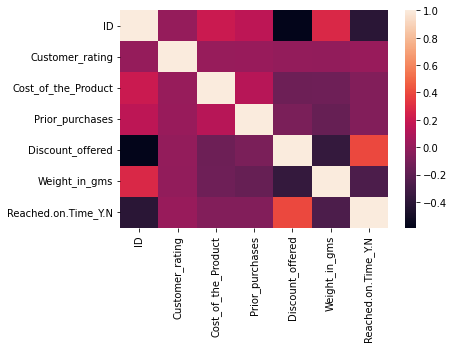

In [225]:
sns.heatmap(viz_frame.corr())

In [226]:
#Average values based on categorical variables

viz_frame.groupby('Gender')['Reached.on.Time_Y.N'].mean()

Gender
F    0.592570
M    0.600852
Name: Reached.on.Time_Y.N, dtype: float64

In [227]:
viz_frame.groupby('Mode_of_Shipment')['Reached.on.Time_Y.N'].mean()

Mode_of_Shipment
Flight    0.592871
Road      0.598039
Ship      0.597296
Name: Reached.on.Time_Y.N, dtype: float64

In [228]:
viz_frame.groupby('Product_importance')['Reached.on.Time_Y.N'].mean()

Product_importance
high      0.659649
low       0.591082
medium    0.590370
Name: Reached.on.Time_Y.N, dtype: float64

In [229]:
viz_frame.groupby('Warehouse_block')['Reached.on.Time_Y.N'].mean()

Warehouse_block
A    0.566055
B    0.595878
C    0.611687
D    0.608045
F    0.599469
Name: Reached.on.Time_Y.N, dtype: float64

array([[<AxesSubplot:title={'center':'Customer_rating'}>,
        <AxesSubplot:title={'center':'Cost_of_the_Product'}>],
       [<AxesSubplot:title={'center':'Prior_purchases'}>,
        <AxesSubplot:title={'center':'Discount_offered'}>],
       [<AxesSubplot:title={'center':'Weight_in_gms'}>, <AxesSubplot:>]],
      dtype=object)

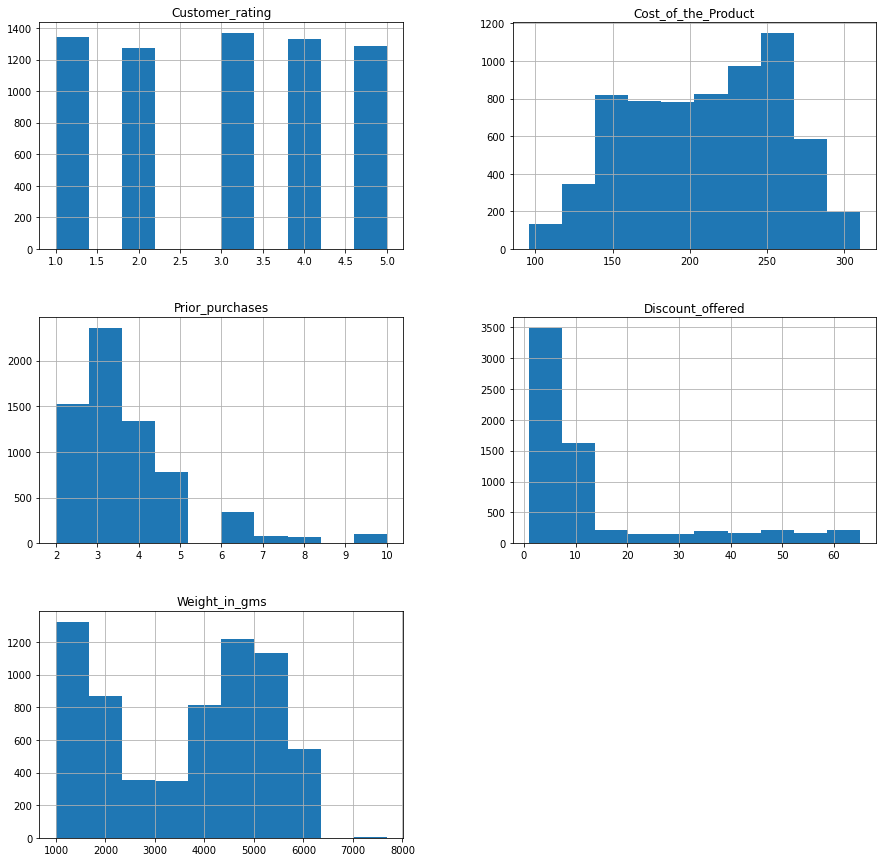

In [230]:
#Check out data distribution to determine transformation to apply

X_train[numerical_feat].hist(figsize=(15,15))

In [231]:
print(X_train[numerical_feat].apply(skew))

Customer_rating       -0.002883
Cost_of_the_Product   -0.165428
Prior_purchases        1.664506
Discount_offered       1.819637
Weight_in_gms         -0.218678
dtype: float64


In [232]:
#Transform 'Discount_offered' and 'Prior_purchases'

log_feat = ['Prior_purchases', 'Discount_offered']

for feature in log_feat:
    X_train[log_feat] = X_train[log_feat].apply(lambda x: np.log1p(x))
    X_test[log_feat] = X_test[log_feat].apply(lambda x: np.log1p(x))

print(X_train[log_feat].apply(skew))

Prior_purchases     0.347815
Discount_offered   -0.106542
dtype: float64


array([[<AxesSubplot:title={'center':'Customer_rating'}>,
        <AxesSubplot:title={'center':'Cost_of_the_Product'}>],
       [<AxesSubplot:title={'center':'Prior_purchases'}>,
        <AxesSubplot:title={'center':'Discount_offered'}>],
       [<AxesSubplot:title={'center':'Weight_in_gms'}>, <AxesSubplot:>]],
      dtype=object)

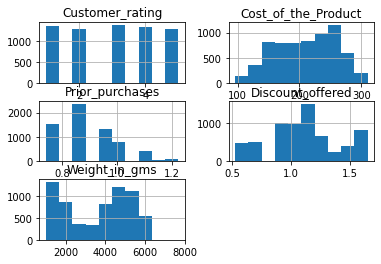

In [233]:
X_train.hist()

In [234]:
#Min-Max transformation

scaler = MinMaxScaler()
X_train[numerical_feat] = scaler.fit_transform(X_train[numerical_feat])
X_test[numerical_feat] = scaler.transform(X_test[numerical_feat])

X_train.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms
0,A,Flight,4,0.5,0.794393,0.592255,high,F,0.446472,0.088134
1,F,Ship,3,0.0,0.364486,0.000000,low,M,0.931555,0.083047
2,F,Road,4,0.0,0.271028,1.000000,high,M,0.621892,0.699237
3,F,Ship,4,0.5,0.289720,0.266592,medium,F,0.838770,0.030824
4,A,Flight,5,0.5,0.369159,0.266592,low,M,0.534033,0.573395


In [235]:
#Encoding of categorical variables

for feature in categorical_feat:
    t_df_train = pd.get_dummies(X_train[feature])
    t_df_test = pd.get_dummies(X_test[feature])

    X_train = pd.concat([X_train, t_df_train], axis=1)
    X_test = pd.concat([X_test, t_df_test], axis=1)

    X_train = X_train.drop(feature, axis=1)
    X_test = X_test.drop(feature, axis=1)

X_train.head()

,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,A,B,C,D,F,...,3,4,5,6,7,high,low,medium,F,M
0,0.5,0.794393,0.592255,0.446472,0.088134,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
1,0.0,0.364486,0.000000,0.931555,0.083047,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,1
2,0.0,0.271028,1.000000,0.621892,0.699237,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0.5,0.289720,0.266592,0.838770,0.030824,0,0,0,0,1,...,0,1,0,0,0,0,0,1,1,0
4,0.5,0.369159,0.266592,0.534033,0.573395,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1


In [253]:
#Grid search

params = {
    'n_estimators': [100, 150, 200],
    'min_samples_split': [2, 20, 40],
    'bootstrap': [True, False]
}

rf_gs = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, scoring='accuracy', cv=5)
rf_gs.fit(X_train, np.ravel(y_train))
rf_gs.best_params_

{'bootstrap': True, 'min_samples_split': 40, 'n_estimators': 100}

In [256]:
#Random Forest classifier

ship_cls = RandomForestClassifier(bootstrap=True, min_samples_split=40, n_estimators=100)
ship_cls.fit(X_train, np.ravel(y_train))

print('score: '+str(ship_cls.score(X_test, np.ravel(y_test))))
print('F1: '+str(f1_score(np.ravel(y_test),ship_cls.predict(X_test))))
print('MAE: '+str(mean_absolute_error(np.ravel(y_test),ship_cls.predict(X_test))))

score: 0.6698477618723018
F1: 0.6757420218701183
MAE: 0.3301522381276982
